# nb-model_xg-dataview

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath
from pathlib import Path
from functools import partial, reduce
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fname = 'nb-model_xg0.ipynb'   # FILL
dir_name = 'model'             # FILL
fix_path(get_cwd(fname, dir_name +sep))

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
from dask import delayed, compute
from torch.utils.data import TensorDataset, DataLoader
import torch

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option('display.max_columns', 50)

from common_util import RECON_DIR, JSON_SFX_LEN, DT_CAL_DAILY_FREQ, is_type, pd_common_idx_rows, remove_dups_list, NestedDefaultDict, set_loglevel, search_df, chained_filter, get_variants, load_df, dump_df, load_json, gb_transpose, pd_common_index_rows, filter_cols_below, inner_join, outer_join, ser_shift, list_get_dict, window_iter, benchmark
from common_util import midx_get_level, pd_rows, midx_intersect, pd_common_idx_rows, midx_split, pd_midx_to_arr, window_iter, np_is_ndim, identity_fn
from model.common import DATASET_DIR, XG_PROCESS_DIR, XG_DATA_DIR, XG_DIR, EXPECTED_NUM_HOURS, default_dataset
from model.xg_util import xgload
from recon.dataset_util import GEN_GROUP_CONSTRAINTS, gen_group
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

CRITICAL:root:script location: /home/kev/crunch/model/nb-model_xg0.ipynb
CRITICAL:root:using project dir: /home/kev/crunch/


## Load Data

In [2]:
assets = ['sp_500', 'russell_2000', 'nasdaq_100', 'dow_jones']

In [3]:
f = xgload(XG_DATA_DIR +'features' +sep)
l = xgload(XG_DATA_DIR +'labels' +sep)
t = xgload(XG_DATA_DIR +'targets' +sep)

In [4]:
print('num f: {}'.format(len(list(f))))
print('num l: {}'.format(len(list(l))))
print('num t: {}'.format(len(list(t))))

num f: 2520
num l: 912
num t: 1360


### ddir / dret

In [5]:
ddir_pba_hoc = {a: list(l.childkeys([a, 'ddir', 'ddir', 'pba_hoc_hdxret_ddir'])) for a in assets}
ddir_vol_hoc = {a: list(l.childkeys([a, 'ddir', 'ddir', 'vol_hoc_hdxret_ddir'])) for a in assets}

In [6]:
dret_pba_hoc = {a: list(t.childkeys([a, 'dret', 'dret', 'pba_hoc_hdxret_dret'])) for a in assets}
dret_vol_hoc = {a: list(t.childkeys([a, 'dret', 'dret', 'vol_hoc_hdxret_dret'])) for a in assets}

### ddir1 / dret1

In [7]:
ddir1_pba_hoc_lin = {a: list(l.childkeys([a, 'ddir1', 'ddir1_lin', 'pba_hoc_hdxret1_ddir1'])) for a in assets}
ddir1_pba_hoc_log = {a: list(l.childkeys([a, 'ddir1', 'ddir1_log', 'pba_hoc_hdxret1_ddir1'])) for a in assets}
ddir1_vol_hoc_lin = {a: list(l.childkeys([a, 'ddir1', 'ddir1_lin', 'vol_hoc_hdxret1_ddir1'])) for a in assets}
ddir1_vol_hoc_log = {a: list(l.childkeys([a, 'ddir1', 'ddir1_log', 'vol_hoc_hdxret1_ddir1'])) for a in assets}

In [8]:
dret1_pba_hoc_lin = {a: list(t.childkeys([a, 'dret1', 'dret1_lin', 'pba_hoc_hdxret1_dret1'])) for a in assets}
dret1_pba_hoc_log = {a: list(t.childkeys([a, 'dret1', 'dret1_log', 'pba_hoc_hdxret1_dret1'])) for a in assets}
dret1_vol_hoc_lin = {a: list(t.childkeys([a, 'dret1', 'dret1_lin', 'vol_hoc_hdxret1_dret1'])) for a in assets}
dret1_vol_hoc_log = {a: list(t.childkeys([a, 'dret1', 'dret1_log', 'vol_hoc_hdxret1_dret1'])) for a in assets}

## Play

In [24]:
hdod = {a: list(f.childkeys([a, 'hduni'])) for a in assets}

In [53]:
chosen_asset = 'sp_500'
chosen_data = hdod[chosen_asset]
print(len(chosen_data))
print([cho[-1] for cho in chosen_data])
ddf = f[chosen_data[28]]

88
['pba_hlh_hlogret_hdmx_hduni(2)', 'pba_hlh_hlogret_hdmx_hduni(3)', 'pba_hlh_hlogret_hdmx_hduni(4)', 'pba_hlh_hlogret_hdmx_hduni(8)', 'pba_hlh_hret_hdmx_hduni(2)', 'pba_hlh_hret_hdmx_hduni(3)', 'pba_hlh_hret_hdmx_hduni(4)', 'pba_hlh_hret_hdmx_hduni(8)', 'pba_hlh_hspread_hdmx_hduni(2)', 'pba_hlh_hspread_hdmx_hduni(3)', 'pba_hlh_hspread_hdmx_hduni(4)', 'pba_hlh_hspread_hdmx_hduni(8)', 'pba_hoc_hlogret_hdmx_hduni(2)', 'pba_hoc_hlogret_hdmx_hduni(3)', 'pba_hoc_hlogret_hdmx_hduni(4)', 'pba_hoc_hlogret_hdmx_hduni(8)', 'pba_hoc_hret_hdmx_hduni(2)', 'pba_hoc_hret_hdmx_hduni(3)', 'pba_hoc_hret_hdmx_hduni(4)', 'pba_hoc_hret_hdmx_hduni(8)', 'pba_hoc_hspread_hdmx_hduni(2)', 'pba_hoc_hspread_hdmx_hduni(3)', 'pba_hoc_hspread_hdmx_hduni(4)', 'pba_hoc_hspread_hdmx_hduni(8)', 'pba_hohlca_hdmx_hduni(2)', 'pba_hohlca_hdmx_hduni(3)', 'pba_hohlca_hdmx_hduni(4)', 'pba_hohlca_hdmx_hduni(8)', 'vol_hlh_hlogret_hdmx_hduni(2)', 'vol_hlh_hlogret_hdmx_hduni(3)', 'vol_hlh_hlogret_hdmx_hduni(4)', 'vol_hlh_hlogret_

In [46]:
ddf

,,8,9,10,11,12,13,14,15
id0,id1,,,,,,,,
2009-01-02,vol_lh,1,2,1,1,1,1,2,1
2009-01-05,vol_lh,1,2,1,1,1,2,1,1
2009-01-06,vol_lh,1,2,1,1,1,2,2,1
2009-01-07,vol_lh,2,1,1,1,1,2,1,1
2009-01-08,vol_lh,2,2,2,1,1,2,2,1
...,...,...,...,...,...,...,...,...,...
2017-12-22,vol_lh,1,1,2,1,1,1,2,1
2017-12-26,vol_lh,2,2,1,1,1,1,1,1
2017-12-27,vol_lh,2,2,2,2,1,2,1,1


In [165]:
def pd_name_range(pd_obj):
    return pd.DataFrame({col: {'min': pd_obj.loc[:, col].min(), 'max': pd_obj.loc[:, col].max()} for col in pd_obj}).T

In [188]:
chosen_asset = 'sp_500'
ddf = f[dc[chosen_asset][1]]

In [190]:
for dkey in dc[chosen_asset]:
    print(dkey)
    mmx = pd_name_range(f[dkey])
    
    print(len(mmx[mmx['min'] < 0]), ' / ', len(mmx))

['sp_500', 'dc', 'dc_trmi3_news', 'trmi3_etf3_news_forecast_dc', 'trmi3_etf3_news_forecast_dc']
6  /  11
['sp_500', 'dc', 'dc_trmi3_news', 'trmi3_etf3_news_fundamental_dc', 'trmi3_etf3_news_fundamental_dc']
6  /  11
['sp_500', 'dc', 'dc_trmi3_news', 'trmi3_etf3_news_sentiment_dc', 'trmi3_etf3_news_sentiment_dc']
4  /  11
['sp_500', 'dc', 'dc_trmi3_news', 'trmi3_mkt3_news_bank_dc', 'trmi3_mkt3_news_bank_dc']
3  /  5
['sp_500', 'dc', 'dc_trmi3_news', 'trmi3_mkt3_news_bond_dc', 'trmi3_mkt3_news_bond_dc']
9  /  11
['sp_500', 'dc', 'dc_trmi3_news', 'trmi3_mkt3_news_stock_dc', 'trmi3_mkt3_news_stock_dc']
10  /  11
['sp_500', 'dc', 'dc_trmi3_social', 'trmi3_etf3_social_forecast_dc', 'trmi3_etf3_social_forecast_dc']
6  /  11
['sp_500', 'dc', 'dc_trmi3_social', 'trmi3_etf3_social_fundamental_dc', 'trmi3_etf3_social_fundamental_dc']
6  /  11
['sp_500', 'dc', 'dc_trmi3_social', 'trmi3_etf3_social_sentiment_dc', 'trmi3_etf3_social_sentiment_dc']
5  /  11
['sp_500', 'dc', 'dc_trmi3_social', 'trmi3_

In [191]:
RETURN_FN_MAPPING = {
	"spread": (lambda ser: ser.diff(1)),
	"ret": (lambda ser: ser.pct_change()),
	"logret": (lambda ser: np.log(1+ser.pct_change()))
}
def single_returnify(ret_type, thresh=None, clip=False):
	"""
	Spread, regular return, or log return.
	"""
	ret_fn = RETURN_FN_MAPPING.get(ret_type)

	def fn(ser):
		ret = ret_fn(ser)
		if (thresh is not None):
			ret = ser_range_center_clip(ret, thresh, inner=SIDEWAYS, outer=clip, inclusive=False)
		return ret
	return fn

In [192]:
RANK_FN_MAPPING = {
	"zn": (lambda ser: (ser.iloc[-1]-ser.mean()) / ser.std()),
	"mx": (lambda ser: 2 * ((ser.iloc[-1]-ser.min()) / (ser.max()-ser.min())) - 1),
	"od": (lambda ser, normalize=True: ser.rank(numeric_only=True, ascending=True, pct=normalize).iloc[-1]),
	"pt": (lambda ser: (ser.iloc[-1]-ser.min()) / (ser.max()-ser.min()))
}

def window_rank(rank_type, num_periods):
	rank_fn = RANK_FN_MAPPING.get(rank_type)

	def fn(ser):
		if (num_periods==-1):
			win = ser.dropna().expanding(min_periods=1)
		else:
			win = ser.dropna().rolling(window=num_periods, min_periods=1)
		return win.apply(rank_fn, raw=False)

	return fn

zn = window_rank('zn', -1)
mx = window_rank('mx', -1)
od = window_rank('od', -1)
pt = window_rank('pt', -1)

In [241]:
num_df=0
num_col=4
s = ddf.iloc[:, num_col]
rk = window_rank('zn', -1)
r = single_returnify('spread')

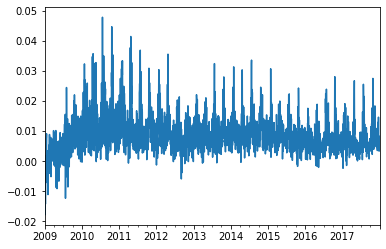

In [242]:
display(s.plot())

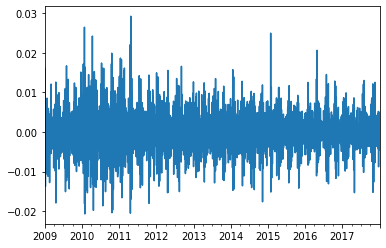

In [243]:
display(r(s).plot())

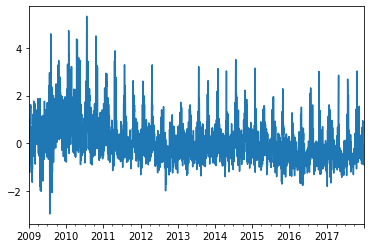

In [244]:
display(rk(s).plot())

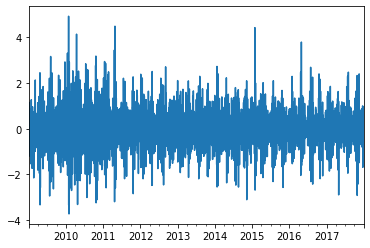

In [245]:
display(rk(r(s)).plot())